# IMDb Movie Review Sentiment Classifier

This notebook builds a binary text classification model using TensorFlow, TensorFlow Hub, and the IMDb Reviews dataset.  
We'll use a pretrained sentence embedding from TFHub and build a feedforward neural network to classify reviews as positive or negative.

In [2]:
pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 5.0 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 5.6 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 5.7 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 6.0 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.1 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.1 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   --------------------------- ------------ 1.6/2.3 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [4]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [5]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=("train[:60%]", "train[60%:]", "test"),
    as_supervised=True
)

In [6]:
@tf.function
def embed_text(text, label):
    embedded_text = embed(tf.expand_dims(text, 0))   # (1, 512)
    embedded_text = tf.squeeze(embedded_text, axis=0)  # (512,)
    return embedded_text, label

# --- Map + Batch + Prefetch (no output_signature needed) ---
train_embed = train_data.map(embed_text).batch(512).prefetch(tf.data.AUTOTUNE)
val_embed = validation_data.map(embed_text).batch(512).prefetch(tf.data.AUTOTUNE)
test_embed = test_data.map(embed_text).batch(512).prefetch(tf.data.AUTOTUNE)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,), dtype=tf.float32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # output logits
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,225 (32.13 KB)

 Trainable params: 8,225 (32.13 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_embed,
    validation_data=val_embed,
    epochs=5
)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4986 - loss: 0.6758 - val_accuracy: 0.4990 - val_loss: 0.6188
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5200 - loss: 0.6005 - val_accuracy: 0.6312 - val_loss: 0.5469
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6644 - loss: 0.5320 - val_accuracy: 0.7393 - val_loss: 0.4882
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7520 - loss: 0.4764 - val_accuracy: 0.7786 - val_loss: 0.4430
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7879 - loss: 0.4339 - val_accuracy: 0.8018 - val_loss: 0.4109


In [9]:
results = model.evaluate(test_embed, verbose=2)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

49/49 - 77s - 2s/step - accuracy: 0.7982 - loss: 0.4101

Test Loss: 0.4101
Test Accuracy: 79.82%


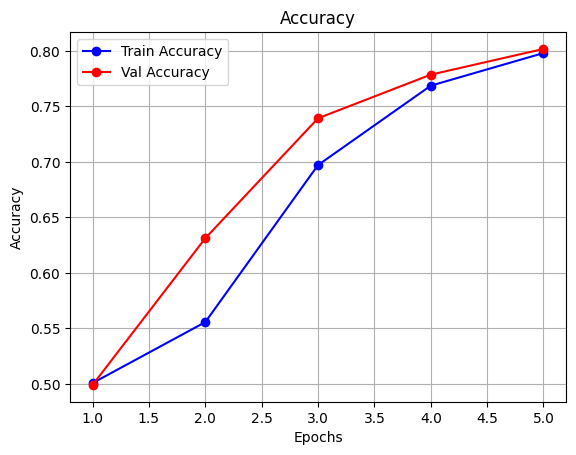

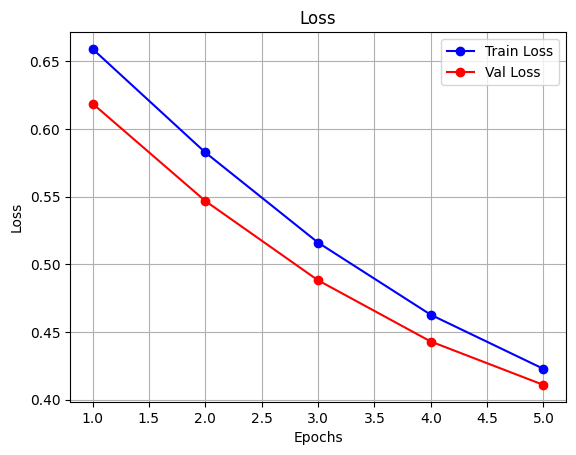

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, loss, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def predict_sentiment(review):
    review_embed = embed([review])  # shape: (1, 512)
    prediction = model.predict(review_embed)[0][0]
    sentiment = "Positive" if prediction > 0 else "Negative"
    print(f"\nReview: {review}")
    print(f"Prediction Score: {prediction:.3f} → Sentiment: {sentiment}")

In [13]:
predict_sentiment("The movie was fantastic! Best I've seen this year.")
predict_sentiment("It was a complete waste of time. Poor plot and bad acting.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

Review: The movie was fantastic! Best I've seen this year.
Prediction Score: 1.265 → Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Review: It was a complete waste of time. Poor plot and bad acting.
Prediction Score: -3.417 → Sentiment: Negative
